# Solartainer
Reminder: the basic concepts of the cadCAD library:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters
* Policies

__Model description__  
* Here we model a solartainer that feeds a single consumer (either a single household or multiple households connected to the same knot).
* The model consists of a consumer, battery, photovoltaic power station, and power grid. The power grid serves as backup, i.e., it is only employed if total demand is not met. Otherwise, power is drawn from the battery or photovoltaic station.



In [29]:
%%capture
import pandas as pd
import math
from numpy.random import rand
from numpy import exp, arange, linspace

cols = [1]
# Get consumption
cons = pd.read_excel('data/StromVerbraeuche.xlsx', index_col=1, usecols=1)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
initial_conditions = {
    'SOC': 0.5, # initial state of charge of battery
    'Pcons': 0, # consumption at t=0 is zero
    'Pgrid': 0 # No power is drawn from the grid at t=0
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

delta_t = 1 # time discretization step length in seconds
P_rated = 10 # rated battery power
Cap_rated = 2 # rated battery capacity
eff = 0.9 # battery efficiency


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
simulation_parameters = {
    'T': range(200),
    'N': 1, # We'll run the same simulation 50 times; the random events in each simulation are independent
    'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We specify the battery's logic in a Policy Function
    
def charge_battery(params, step, sL, s):

    # Reformat vector of consumer demand per time step
    Pcon = cons.as_matrix();
    
    # Compute total consumption and available power
    # Solar power
    Psolar = 0.5*math.exp( -(0.01*(s['timestep']-108))**2 );
    # Consumer demand
    P_consumption = Pcon[s['timestep']][0]/2;
    # Total available power after demand has been met
    Ptot = P_consumption - Psolar; #-Pcon(s['timestep']);
    E_Batt_diff = - Ptot*delta_t
    P_grid = 0
    
    
    # Compute charge
    if (- Ptot <= P_rated and s['SOC'] <= 1 and - Ptot >= -P_rated and s['SOC'] >= 0):
        E_Batt_diff = max(min(- Ptot*delta_t*delta_t,P_rated*delta_t),-P_rated*delta_t)
    elif (- Ptot*delta_t > P_rated*delta_t and s['SOC'] < 1):
        E_Batt_diff = P_rated*delta_t
    elif (- Ptot*delta_t < -P_rated*delta_t and s['SOC'] > 0) :
        E_Batt_diff = - P_rated*delta_t
    else :
        E_Batt_diff = 0 # max(min(E_Batt_diff*delta_t,P_rated*delta_t),-P_rated*delta_t)
         
    E_Batt_diff = max(min(- Ptot*delta_t*delta_t,P_rated*delta_t),-P_rated*delta_t)
    # Charge cannot lead to SOC being larger than 1 or smaller than 0
    if s['SOC'] + E_Batt_diff > 1:
        E_Batt_diff = 1- s['SOC']
    elif s['SOC'] + E_Batt_diff < 0:
        E_Batt_diff = -s['SOC']
        
    # Compute electricity drawn from the grid
    P_grid = Ptot - E_Batt_diff
    return({'E_Batt_diff': E_Batt_diff, 'P_consumption': P_consumption, 'P_grid': P_grid})
    

    
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# State update functions
def charge(params, step, sL, s, _input):
    y = 'SOC'
    x = s['SOC'] + _input['E_Batt_diff']
    return (y, x)

def get_consumption(params, step, sL, s, _input):
    y = 'Pcons'
    x = _input['P_consumption']
    return (y, x)

def get_grid_input(params, step, sL, s, _input):
    y = 'Pgrid'
    x = _input['P_grid']
    return (y, x)


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'charge_battery': charge_battery,
            #'charge_battery_2': charge_battery_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'SOC': charge,
            'Pcons': get_consumption,
            'Pgrid':get_grid_input
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [30]:
%%capture
from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
df = pd.DataFrame(raw_result)

In [31]:
from IPython.display import display
tmp_rows = pd.options.display.max_rows
pd.options.display.max_rows = 10
display(df.set_index(['run', 'timestep', 'substep']))
pd.options.display.max_rows = tmp_rows

SOC  Pcons     Pgrid
run timestep substep                           
1   0        0        0.500000   0.00  0.000000
    1        1        0.515743   0.14 -0.031486
    2        1        0.534871   0.14 -0.038255
    3        1        0.567424   0.13 -0.065107
    4        1        0.543445   0.19  0.047960
...                        ...    ...       ...
    196      1        1.000000   0.21 -0.024559
    197      1        0.990490   0.24  0.019020
    198      1        0.886936   0.33  0.207107
    199      1        0.719366   0.39  0.335141
    200      1        0.587805   0.35  0.263122

[201 rows x 3 columns]

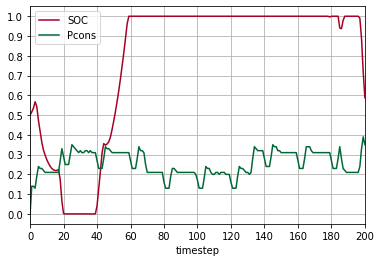

In [32]:
ax = None
for i in range(simulation_parameters['N']):
    ts = df['timestep'].drop_duplicates()
    a = arange(len(ts))
    ts = ts[(a % 20 == 0)]
    ax = df[df['run']==i+1].plot('timestep', ['SOC', 'Pcons'],
                                     grid=True,
                                     xticks=list(ts), 
                                     yticks=list(linspace(0,math.ceil(max(df['SOC'].max(),1*df['Pcons'].max())),11)),
                                     legend = (ax == None),
                                     colormap = 'RdYlGn',
                                     ax = ax
                                  )

## Mini Monte Carlo simulation (just two runs)
We simulate two different versions of the same system. To this end, we create two `Configuration` objects to pass to the `Executor` instead of just one.

In [33]:
initial_conditions_1 = {
    'SOC': 0.99, 
    'Pcons': 0 ,
    'Pgrid':0
}

initial_conditions_2 = {
    'SOC': 0.3, 
    'Pcons': 0,
    'Pgrid':0
}

Just like we did before, we package those initial conditions along with the partial state update blocks and the simulation parameters into `Configuration` objects

In [34]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config_1 = Configuration(initial_state=initial_conditions_1, #dict containing variable names and initial values
                        partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                        sim_config=simulation_parameters #dict containing simulation parameters
                       )

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config_2 = Configuration(initial_state=initial_conditions_2, #dict containing variable names and initial values
                        partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                        sim_config=simulation_parameters #dict containing simulation parameters
                       )

And now we can execute the simulation of those two different versions of the system in parallel. In order to accomplish that, we use an `ExecutionContext` of mode `multi_proc`

In [35]:
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc) # For Monte Carlo sim. we use multi_proc instead of single_proc
executor = Executor(exec_context, [config_1, config_2]) # Pass the configuration objects inside an array

And we are ready to execute the simulation. The `execute()` method will return a list of tuples - the first element of those tuples correspond to the datapoints of each one of the versions of the system being simulated.

In [36]:
%%capture
results = []
for raw_result, tensor in executor.execute():
    df = pd.DataFrame(raw_result)
    results.append(df)

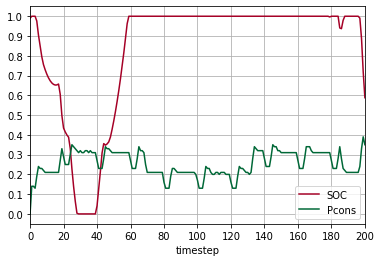

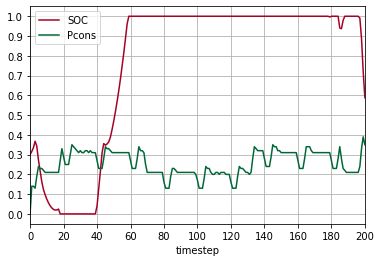

In [37]:
for df in results:
    ax = None
    for i in range(simulation_parameters['N']):
        ax = df[df['run']==i+1].plot('timestep', ['SOC', 'Pcons'],
                                     grid=True,
                                     xticks=list(ts), 
                                     yticks=list(linspace(0,math.ceil(max(df['SOC'].max(),1*df['Pcons'].max())),11)),
                                     legend = (ax == None),
                                     colormap = 'RdYlGn',
                                     ax = ax
                                  )

The same thing can be done for any sort of variation in the system being modeled: wheter it's the inclusion of a new state update function, a change in the order in which partial state update blocks get executed, or completely different policy and state update functions, all we need to do is create a different `Configuration` object for each one of the variations and pass those to the `Executor`.